Fallback .CSV

In [1]:
import pandas as pd

def load_flight_data(csv_path):

    try:
        df = pd.read_csv(csv_path)
        print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
        return df
    except Exception as e:
        print("Error loading CSV:", e)
        raise

DataLoader Function SQL Modified

In [2]:
import pandas as pd
import mysql.connector

def load_flight_data_mysql(host, user, password, database, table):
    conn = mysql.connector.connect(
        host=host,
        user=user,
        password=password,
        database=database
    )

    query = f"SELECT * FROM {table}"
    df = pd.read_sql(query, conn)

    conn.close()
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    return df


Preprocessing Function

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def preprocess_data(df):
    
    df = df.copy()

    # Drop rows with all missing values
    df.dropna(how="all", inplace=True)
    df.fillna(0, inplace=True)


    # Label Encoding for categorical columns
    cat_cols = ["carrier", "carrier_name", "airport", "airport_name"]
    encoder = LabelEncoder()

    for col in cat_cols:
        if col in df.columns:
            df[col] = encoder.fit_transform(df[col].astype(str))

    return df


def create_delay_label(df):

    df["delayed"] = df["arr_del15"].apply(lambda x: 1 if x >= 1 else 0)
    return df

Plots Function

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def run_eda(df):
    
     # Plot 1 — Distribution of Delays
    plt.figure(figsize=(7, 5))
    sns.countplot(x="delayed", data=df)
    plt.title("Flight Delay Distribution")
    plt.xlabel("Delayed (1=yes)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("plot_delay_distribution.png")

    # Plot 2 — Delays by Airport
    plt.figure(figsize=(10, 5))
    sns.barplot(x="airport", y="arr_delay", data=df)
    plt.title("Average Arrival Delay by Airport")
    plt.tight_layout()
    plt.savefig("plot_delay_by_airport.png")

    # Plot 3 — Heatmap of correlations
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.savefig("plot_correlation_heatmap.png")

    print("EDA plots saved.")

Models Function

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def train_models(df):
    feature_cols = [
        "month", "carrier", "airport", "arr_flights",
    ]

    X = df[feature_cols]
    y = df["delayed"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )

    # Model 1: Logistic Regression
    log_reg = LogisticRegression(max_iter=2000)
    log_reg.fit(X_train, y_train)

    # Model 2: Random Forest
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    
    return ({"Logistic Regression": log_reg, "Random Forest": rf}, X_test, y_test)


def evaluate_models(models, X_test, y_test):
    for model_name, model in models.items():
        preds = model.predict(X_test)

        print("\n==============================")
        print(f"MODEL: {model_name}")
        print("==============================")

        print("Accuracy:", accuracy_score(y_test, preds))
        print("Precision:", precision_score(y_test, preds))
        print("Recall:", recall_score(y_test, preds))
        print("\nClassification Report:\n", classification_report(y_test, preds))

Main Function


MySQL not available. Falling back to CSV.
Reason: 2005 (HY000): Unknown MySQL server host 'cap4770' (11001)
Rows: 9494, Columns: 21

=== PREPROCESSING ===

=== EXPLORATORY DATA ANALYSIS (EDA) ===
EDA plots saved.

=== TRAINING MODELS ===

=== EVALUATION ===

MODEL: Logistic Regression
Accuracy: 0.9776748104465038
Precision: 0.9784172661870504
Recall: 0.9991356957649092

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.15      0.25        60
           1       0.98      1.00      0.99      2314

    accuracy                           0.98      2374
   macro avg       0.90      0.57      0.62      2374
weighted avg       0.97      0.98      0.97      2374


MODEL: Random Forest
Accuracy: 0.9776748104465038
Precision: 0.983326207781103
Recall: 0.9939498703543648

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.35      0.44        60
           1       0.98      0.99 

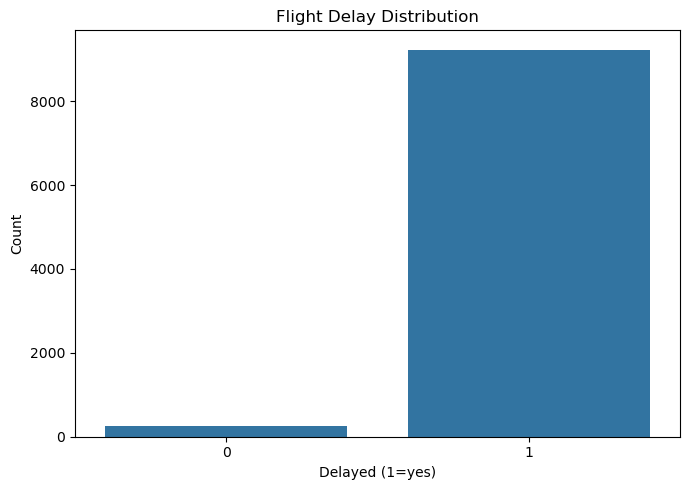

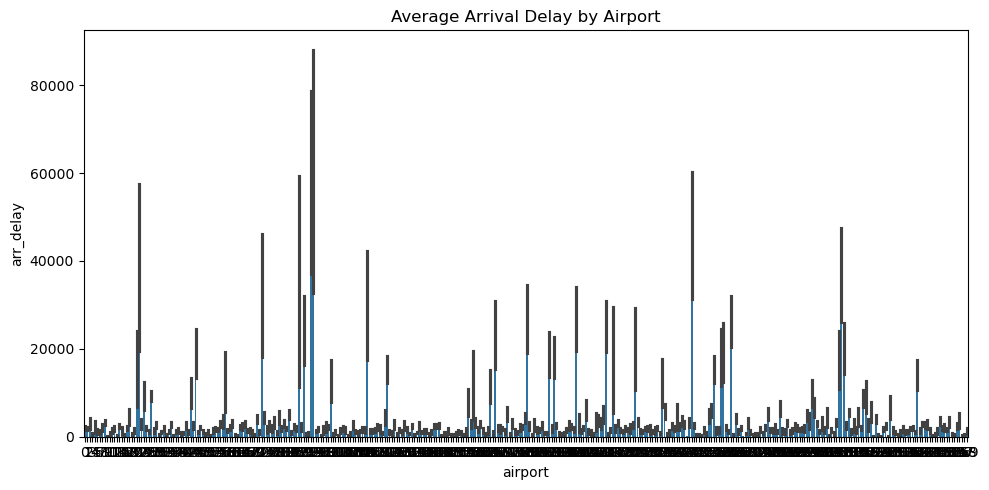

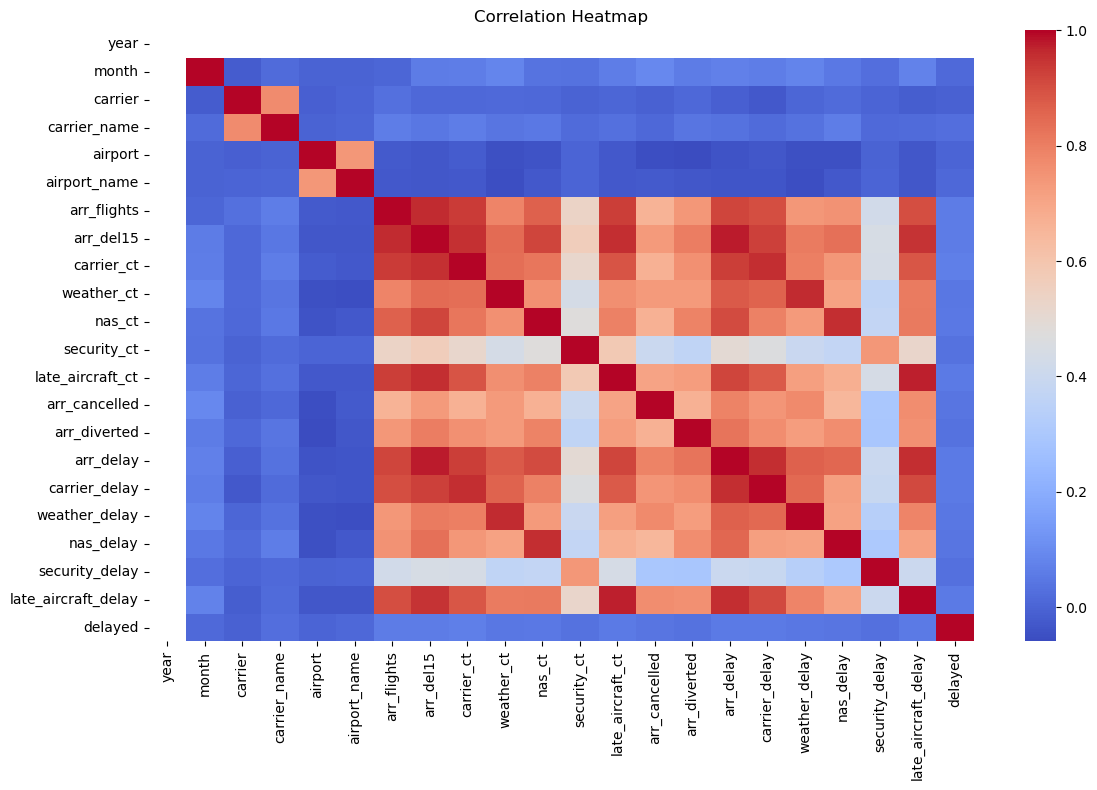

In [6]:
# main.py
# CAP 4770 Final Project – Flight Delay Prediction
# Group: Ryan Blankenbeker, Kenyen Hast-Otero, John WG Wallace


def main():

    USE_MYSQL = True

    try:
        if USE_MYSQL:
            df = load_flight_data_mysql(
                host="cap4770",
                user="root",
                password="Romeo",
                database="cap4770",
                table="airline_delays"
            )
        else:
            raise Exception("Forcing CSV mode")

    except Exception as e:
        print("\nMySQL not available. Falling back to CSV.")
        print("Reason:", e)
        df = load_flight_data("Airline_Delay_Cause.csv")

    print("\n=== PREPROCESSING ===")
    df = preprocess_data(df)
    df = create_delay_label(df)

    print("\n=== EXPLORATORY DATA ANALYSIS (EDA) ===")
    run_eda(df)

    print("\n=== TRAINING MODELS ===")
    models, X_test, y_test = train_models(df)

    print("\n=== EVALUATION ===")
    evaluate_models(models, X_test, y_test)


if __name__ == "__main__":
    main()
